# Bonus1.1: Federated Averaging

### Name: Vincent Lee


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Parallel/Parallel.pdf)

2. Implement **federated averaging** or decentralized optimization.

3. Plot the convergence curve. (The x-axis can be ```number of epochs``` or ```number of communication```. You must make sure the label is correct.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo. (If it is submitted to Google Drive or Dropbox, you must make the file open-access.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus1/Bonus1.html



# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [1]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [2]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [3]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[-0.10808416 -0.03471856 -0.01462    -0.05470593 -0.07007434  0.02860758
   0.0088452  -0.18687622]]
test std = 
[[0.94089388 0.93906017 0.93208047 1.02178425 0.88636636 0.81318187
  0.85108677 0.83411139]]


## 1.4. Add a dimension of all ones

In [4]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


# 2. Minibatch Gradient Descent 

In [5]:
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: d-by-1 matrix
#     xi: b-by-d matrix
#     yi: b-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def mb_stochastic_objective_gradient(w, xi, yi, lam, b):
    b, d = xi.shape
    yx = numpy.multiply(yi,xi) # b by d matrix
    yxw = numpy.dot(yx,w) # b by 1 vector
    vec1 = numpy.exp(-1 * yxw) 
    vec2 = numpy.log(1+vec1) 
    loss = numpy.mean(vec2)
    reg = lam / 2 * numpy.sum(numpy.multiply(w,w))
    obj = loss + reg
    
    g_vec = -yx / (1 + numpy.exp(yxw))
    g = numpy.mean(g_vec,axis=0).reshape(d,1)
    g += lam * w
    
    return obj, g

In [6]:
import ray

ray.init()

@ray.remote
class Server:
    def __init__(self,m,d, stepsize):
        self.m = m # number of workers
        self.d = d # number of parameters 
        self.weight = numpy.zeros((d,1))
        self.stepsize = stepsize
        self.objvals = []
        
    def broadcast(self):
        return self.weight,self.stepsize
    
    def aggregate(self,objvals,weights):
        crnt_obj = 0 
        crnt_gradient = numpy.zeros((self.d,1))
        for i in range(self.m):
            crnt_gradient += weights[i]
            crnt_obj += objvals[i]
        crnt_gradient /= self.m
        crnt_obj /= self.m
        self.weight = crnt_gradient
        self.objvals.append(crnt_obj)
        self.stepsize *= .9 
    
    def get_objvals(self):
        return self.objvals

2020-03-20 19:59:20,047	INFO resource_spec.py:212 -- Starting Ray with 8.79 GiB memory available for workers and up to 4.41 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-03-20 19:59:20,336	INFO services.py:1123 -- View the Ray dashboard at localhost:8265


In [7]:
@ray.remote
class Worker:
    def __init__(self,x,y,b,iterations):
        self.n = x.shape[0]
        self.d = x.shape[1]
        rand_indices = numpy.random.permutation(self.n)
        self.x = x[rand_indices,:]
        self.y = y[rand_indices,:]
        self.b = b
        
        # how many times to run in one update
        self.iterations = iterations
        
        # index for keeping track of epoch
        self.crnt_index = 0
        self.max_index = self.n // b
   
    def update_params(self,weight,stepsize):
        self.weight = weight
        crnt_obj = 0
        
        for i in range(self.iterations):
            # starting index
            start = self.crnt_index * b
            # ending index
            end = (self.crnt_index+1) * b
            xi = self.x[start:end,:]
            yi = self.y[start:end,:]
            obj, w = mb_stochastic_objective_gradient(self.weight,xi,yi,stepsize,self.b)
            
            #update weight and objective value
            self.weight = self.weight - stepsize * w
            crnt_obj += obj
            
            stepsize *= .9
            
            # increment your index
            # if you are at the max it means one epoch 
            self.crnt_index += 1
            if self.crnt_index == self.max_index:
                rand_indices = numpy.random.permutation(self.n)
                self.x = x[rand_indices,:]
                self.y = y[rand_indices,:]
                self.crnt_index = 0
                
        crnt_obj /= self.iterations
        return crnt_obj, self.weight

In [8]:
# GD (Mini-Batch w/batch size b=640/4)
lam = 1E-6 # do not change
b = n_train//4 
stepsize = 0.4 # you must tune this parameter
m = 4
communications = 300
d = x_train.shape[1]
iterations = 1

server = Server.remote(m,d,stepsize)
workers = []
chunksize = n_train // m
for i in range(m):
    x = x_train[i*chunksize:(i+1)*chunksize,:]
    y = y_train[i*chunksize:(i+1)*chunksize,:]
    workers.append(Worker.remote(x,y,b,iterations))

    
for i in range(communications):
    objvals = []
    weights = []
    futures = []
    w, stepsize = ray.get(server.broadcast.remote())
    for worker in workers:
        futures.append(worker.update_params.remote(w,stepsize))
    for future in futures:
        obj, weight = ray.get(future)
        objvals.append(obj)
        weights.append(weight)
    server.aggregate.remote(objvals,weights)

gd_q1_objvals = ray.get(server.get_objvals.remote())

ray.shutdown()

In [9]:
ray.init()
# GD (Mini-Batch w/batch size b=640/4)
lam = 1E-6 # do not change
b = n_train//4 
stepsize = 0.4 # you must tune this parameter
m = 4
communications = 300
d = x_train.shape[1]
iterations = 8

server = Server.remote(m,d,stepsize)
workers = []
chunksize = n_train // m
for i in range(m):
    x = x_train[i*chunksize:(i+1)*chunksize,:]
    y = y_train[i*chunksize:(i+1)*chunksize,:]
    workers.append(Worker.remote(x,y,b,iterations))

    
for i in range(communications):
    objvals = []
    weights = []
    futures = []
    w, stepsize = ray.get(server.broadcast.remote())
    for worker in workers:
        futures.append(worker.update_params.remote(w,stepsize))
    for future in futures:
        obj, weight = ray.get(future)
        objvals.append(obj)
        weights.append(weight)
    server.aggregate.remote(objvals,weights)

gd_q8_objvals = ray.get(server.get_objvals.remote())
ray.shutdown()

2020-03-20 19:59:21,913	INFO resource_spec.py:212 -- Starting Ray with 8.79 GiB memory available for workers and up to 4.4 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-03-20 19:59:22,177	INFO services.py:1123 -- View the Ray dashboard at localhost:8265


In [10]:
ray.init()
# SGD (Mini-Batch w/batch size b=1)
lam = 1E-6 # do not change
b = 1
stepsize = 0.4 # you must tune this parameter
m = 4
communications = 300
d = x_train.shape[1]
iterations = 1

server = Server.remote(m,d,stepsize)
workers = []
chunksize = n_train // m
for i in range(m):
    x = x_train[i*chunksize:(i+1)*chunksize,:]
    y = y_train[i*chunksize:(i+1)*chunksize,:]
    workers.append(Worker.remote(x,y,b,iterations))

    
for i in range(communications):
    objvals = []
    weights = []
    futures = []
    w, stepsize = ray.get(server.broadcast.remote())
    for worker in workers:
        futures.append(worker.update_params.remote(w,stepsize))
    for future in futures:
        obj, weight = ray.get(future)
        objvals.append(obj)
        weights.append(weight)
    server.aggregate.remote(objvals,weights)

sgd_q1_objvals = ray.get(server.get_objvals.remote())
ray.shutdown()

2020-03-20 19:59:23,782	INFO resource_spec.py:212 -- Starting Ray with 8.79 GiB memory available for workers and up to 4.4 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-03-20 19:59:24,061	INFO services.py:1123 -- View the Ray dashboard at localhost:8265


In [11]:
ray.init()
# SGD (Mini-Batch w/batch size b=1)
lam = 1E-6 # do not change
b = 1
stepsize = 0.4 # you must tune this parameter
m = 4
communications = 300
d = x_train.shape[1]
iterations = 8

server = Server.remote(m,d,stepsize)
workers = []
chunksize = n_train // m
for i in range(m):
    x = x_train[i*chunksize:(i+1)*chunksize,:]
    y = y_train[i*chunksize:(i+1)*chunksize,:]
    workers.append(Worker.remote(x,y,b,iterations))

    
for i in range(communications):
    objvals = []
    weights = []
    futures = []
    w, stepsize = ray.get(server.broadcast.remote())
    for worker in workers:
        futures.append(worker.update_params.remote(w,stepsize))
    for future in futures:
        obj, weight = ray.get(future)
        objvals.append(obj)
        weights.append(weight)
    server.aggregate.remote(objvals,weights)

sgd_q8_objvals = ray.get(server.get_objvals.remote())
ray.shutdown()

2020-03-20 19:59:25,604	INFO resource_spec.py:212 -- Starting Ray with 8.79 GiB memory available for workers and up to 4.4 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-03-20 19:59:25,888	INFO services.py:1123 -- View the Ray dashboard at localhost:8265


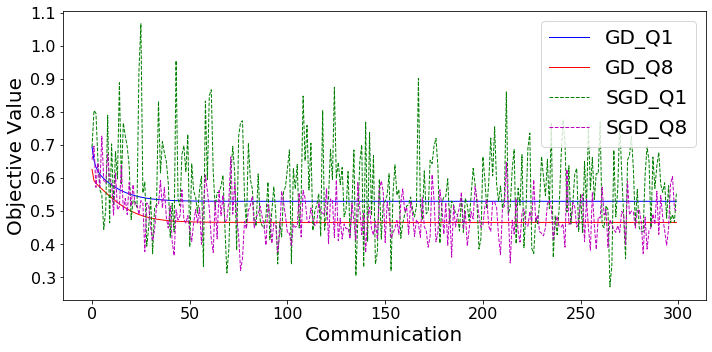

In [13]:
# plot the 4 curves:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10, 5))

gd_q1 = range(len(gd_q1_objvals))
gd_q8 = range(len(gd_q8_objvals))
sgd_q1 = range(len(sgd_q1_objvals))
sgd_q8 = range(len(sgd_q8_objvals))


line0, = plt.plot(gd_q1, gd_q1_objvals, '-b', LineWidth=1)
line1, = plt.plot(gd_q8, gd_q8_objvals, '-r', LineWidth=1)
line2, = plt.plot(sgd_q1, sgd_q1_objvals, '--g', LineWidth=1)
line3, = plt.plot(sgd_q1, sgd_q8_objvals, '--m', LineWidth=1)



plt.xlabel('Communication', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1, line2,line3], ['GD_Q1', 'GD_Q8', 'SGD_Q1', 'SGD_Q8'], fontsize=20)
plt.tight_layout()
plt.show()